In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nohawarda
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:01<00:00, 111MB/s]


In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import shutil
import random

# Define paths
train_dir = '/content/brain-tumor-mri-dataset/Training'
validation_dir = '/content/brain-tumor-mri-dataset/Validation'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

# Move images to the validation folder
os.makedirs(validation_dir, exist_ok=True)

# Move 110 images from each class to the validation folder
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
for cls in classes:
    src_dir = os.path.join(train_dir, cls)
    dest_dir = os.path.join(validation_dir, cls)
    os.makedirs(dest_dir, exist_ok=True)
    image_files = os.listdir(src_dir)
    random.shuffle(image_files)  # Shuffle the list of images
    selected_images = image_files[:110]  # Take the first 110 images
    for img_file in selected_images:
        src_path = os.path.join(src_dir, img_file)
        dest_path = os.path.join(dest_dir, img_file)
        shutil.move(src_path, dest_path)

# Check and remove any unexpected directories in the validation set
for folder in os.listdir(validation_dir):
    if folder not in classes:
        shutil.rmtree(os.path.join(validation_dir, folder))

# Load and preprocess the data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)  # Add test data generator

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x)  # Assuming 4 classes, adjust accordingly
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)




Found 3952 images belonging to 4 classes.
Found 1760 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Epoch 1/10
100/100 [==============================] - 13s 80ms/step - loss: 2.6988 - accuracy: 0.6275 - val_loss: 0.5730 - val_accuracy: 0.7960
Epoch 2/10
100/100 [==============================] - 6s 64ms/step - loss: 0.7468 - accuracy: 0.7515 - val_loss: 0.5235 - val_accuracy: 0.8160
Epoch 3/10
100/100 [==============================] - 7s 69ms/step - loss: 0.5978 - accuracy: 0.7860 - val_loss: 0.6104 - val_accuracy: 0.8110
Epoch 4/10
100/100 [==============================] - 8s 78ms/step - loss: 0.4699 - accuracy: 0.8290 - val_loss: 0.4391 - val_accuracy: 0.8480
Epoch 5/10
100/100 [==============================] - 9s 93ms/step - loss: 0.4052 - accuracy: 0.8504 - val_loss: 0.5965 - val_accuracy: 0.7680
Epoch 6/10
100/100 [==============================] - 6s 60ms/step - loss: 0.3544 - accuracy: 0.8705 - val_loss: 0.4160 - val_accuracy: 0.8530
Epoch 7/10
100/100 [==============================] - 7s 71ms/step - loss: 0.2985 - accuracy: 0.8855 - val_loss: 0.4505 - val_accuracy: 0.861

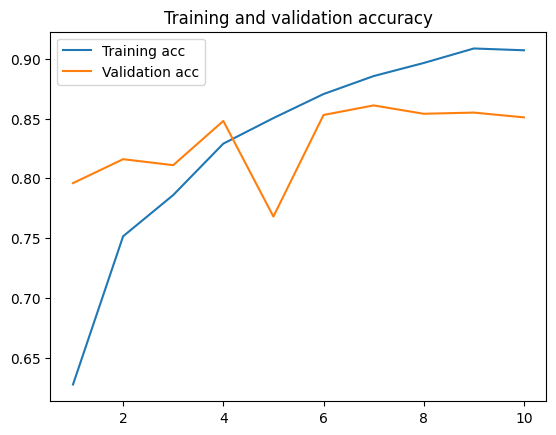

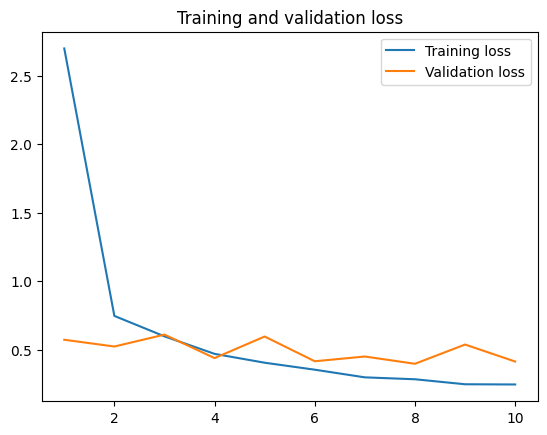

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
